In [5]:
import warnings
warnings.filterwarnings('ignore')

In [82]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import pyecharts
from pyecharts import options as opts
from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import keras
import keras.backend as K
from keras.models import Sequential,load_model
from keras.layers import Dense
from keras.models import Model
from keras import regularizers
from keras.callbacks import TensorBoard
from pyecharts.charts import Line, Page
from scipy.stats import skew
from scipy.stats import kurtosis
from joblib import dump, load

#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)


In [6]:
def line_with_constant_benchmark(data, title, axis_offset=0, zoom=True) -> Line:
    line_ = (
        Line(
            init_opts=opts.InitOpts(
                animation_opts=opts.AnimationOpts(
                    animation=False
                )
            ))
        .add_xaxis(range(len(data)))
        .add_yaxis(
            title,
            data[title].values,
            label_opts=opts.LabelOpts(is_show=False)
        ).set_global_opts(
            datazoom_opts=opts.DataZoomOpts() if zoom else None,
            yaxis_opts=opts.AxisOpts(
                min_=min(data[title].values) - axis_offset,
                max_=max(data[title].values) + axis_offset
            ),
        )
    )
    return line_

def line_with_variated_benchmark(data, title,benchmark_title, axis_offset=0, zoom=True) -> Line:
    line_ = (
        Line(
            init_opts=opts.InitOpts(
                animation_opts=opts.AnimationOpts(
                    animation=False
                )
            ))
        .add_xaxis(range(len(data)))
        .add_yaxis(
            title,
            data[title].values,
            label_opts=opts.LabelOpts(is_show=False)
        )
        .add_yaxis(
            benchmark_title,
            data[benchmark_title].values,
            label_opts=opts.LabelOpts(is_show=False)
        ).set_global_opts(
            datazoom_opts=opts.DataZoomOpts() if zoom else None,
            yaxis_opts=opts.AxisOpts(
                min_=min(data[title].values) - axis_offset,
                max_=max(data[title].values) + axis_offset
            ),
        )
    )
    return line_
    
    
def draw_split_data(split_data_item, title, zoom=True, dir_=None):
    page = Page()
    page.add(line_with_constant_benchmark(
        split_data_item, 
        "出口水分", 
        zoom=zoom
    ))
    page.add(line_with_variated_benchmark(
        split_data_item, 
        "筒壁1区温度实际值", 
        '筒壁1区温度设定值',
        axis_offset=0.5,
        zoom=zoom
    ))
    page.add(line_with_variated_benchmark(
        split_data_item, 
        "筒壁2区温度实际值",
        "筒壁2区温度设定值",
        axis_offset=0.5,
        zoom=zoom
    ))
    page.add(line_with_variated_benchmark(
        split_data_item, 
        "热风速度实际值",
        "热风速度设定值",
        axis_offset=0.01,
        zoom=zoom
    ))
    page.add(line_with_constant_benchmark(
        split_data_item, 
        "烘前叶丝流量", 
        axis_offset=100,
        zoom=zoom
    ))
    page.add(line_with_constant_benchmark(
        split_data_item, 
        "罩压力", 
        zoom=zoom
    ))
    page.add(line_with_constant_benchmark(
        split_data_item, 
        "入口水分",
        zoom=zoom
    ))
    page.add(line_with_constant_benchmark(
        split_data_item, 
        "脱水量", 
        zoom=zoom
    ))
    page.add(line_with_constant_benchmark(
        split_data_item, 
        "烘前叶丝流量累积量", 
        zoom=zoom
    ))
    if dir_:
        make_dir('./plot/' + dir_ )
        page.render('./plot/'+ dir_ + '/'+ title + '.html')
    else:
        page.render('./plot/' + title + '.html')

def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path) 


In [43]:
def format_time(time_str):
    if type(time_str) != 'str':
        return time_str
    try:
        return datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S')
    except ValueError:
        return datetime.strptime(time_str, '%Y-%m-%d')

## Read original Data

In [33]:
original = pd.read_csv('./data.csv', encoding='gbk')
supplement = pd.read_csv('./data1.csv')
supplement['时间'] = supplement['时间'].map(lambda x: format_time(x))
supplement = supplement[supplement['时间'] > '2019-10-28']
original = pd.concat([original, supplement])

original.columns.values

array(['ID', '批次', '牌号', '时间', '生产班次', '生产班别', '设备状态', '烘前叶丝流量设定值',
       '烘前叶丝流量', '烘前叶丝流量累积量', 'SIROX蒸汽流量', '热风温度', '筒壁1区温度设定值',
       '筒壁1区温度实际值', '筒壁2区温度设定值', '筒壁2区温度实际值', '脱水量', '排潮风门开度', '罩压力',
       '热风速度设定值', '热风速度实际值', '出口温度', 'SIROX水分增加', '入口水分', '出口水分设定值',
       '出口水分', '冷凝水温度1区', '冷凝水温度2区', '滚筒转速', '蒸汽压力', '区域1预热阶段滚筒温度额定值',
       '区域2预热阶段滚筒温度额定值', '工作点脱水', '区域1滚筒温度标准工作点', '区域2滚筒温度标准工作点',
       '区域1筒壁蒸汽压力', '区域2筒壁蒸汽压力', '罩压力设定值'], dtype=object)

In [34]:
columns = [
 '时间', '批次', '牌号', '设备状态', \
 '入口水分', '出口水分', '出口水分设定值', '烘前叶丝流量累积量', \
 '热风速度设定值',  '热风速度实际值', '热风温度', \
 '烘前叶丝流量设定值', '烘前叶丝流量', \
 '筒壁1区温度设定值', '筒壁1区温度实际值',   \
 '筒壁2区温度实际值', '筒壁2区温度设定值', \
 '脱水量', '工作点脱水', '罩压力', '罩压力设定值', '排潮风门开度', \
 '区域1筒壁蒸汽压力', '区域2筒壁蒸汽压力'
]

data = original[columns]
# data = original
data['出口水分差值'] = data['出口水分'] - data['出口水分设定值']

# 对总的数据进行预处理

In [35]:
# drop nan
data = data.dropna()

# 牌号莫名奇妙的存储时间，drop这些行
index = data[[isinstance(item, str) and item.startswith('2019') for item in data['牌号']]].index
data = data.drop(index, axis=0)

# 烘前叶丝流量 == 0，表示设备没有运行
index = data[data['烘前叶丝流量'] == 0].index
data = data.drop(index, axis=0)

# 只考虑 '准备', '启动', '生产', '收尾' 四个状态的数据
data = data[data['设备状态'].isin(['准备', '启动', '生产', '收尾'])]

# 过滤批次为 '000'的数据
data = data[data['批次'] != '000']

# 对数据进行分割
1. split_data_per_number 存储每个牌号的数据
2. split_data_per_number[0] 为第一个牌号下所有的生产批次的数据

In [36]:
criterion = {}
for number in data['牌号'].unique():
    sample_per_number = data[data['牌号'] == number]
    criterion[number] = np.round(sample_per_number['出口水分设定值'].mean(), 2)

In [44]:
data = data[data['设备状态'] == '生产']

split_data_per_number = []
for number in data['牌号'].unique():
    sample_per_number = data[data['牌号'] == number]
    split_data_per_batch = []
    
    for batch in sample_per_number['批次'].unique():
        sample_per_batch = sample_per_number[sample_per_number['批次'] == batch]

        sample_per_batch['时间'] = sample_per_batch['时间'].map(lambda x: format_time(x))
        sample_per_batch = sample_per_batch.sort_values(by=['时间'], ascending=True)
        
        split_data_per_batch.append(sample_per_batch)

    split_data_per_number.append(split_data_per_batch)
    
    print(number, '批次数量: ', len(split_data_per_batch))

Txy### 批次数量:  105
TG####A 批次数量:  329
HSX### 批次数量:  60
TH####A 批次数量:  251
DQMr## 批次数量:  2
ThQD##A 批次数量:  2
HsxY## 批次数量:  115
HR#### 批次数量:  26


In [792]:
split_data_per_number[2][0].head()

,时间,批次,牌号,设备状态,入口水分,出口水分,出口水分设定值,烘前叶丝流量累积量,热风速度设定值,热风速度实际值,热风温度,烘前叶丝流量设定值,烘前叶丝流量,筒壁1区温度设定值,筒壁1区温度实际值,筒壁2区温度实际值,筒壁2区温度设定值,脱水量,工作点脱水,罩压力,罩压力设定值,排潮风门开度,区域1筒壁蒸汽压力,区域2筒壁蒸汽压力,出口水分差值
43094,2019-04-20 08:18:58,1904HSX###015_03,HSX###,准备,3.118547,1.68,13.8,0.0,0.4,0.273459,110.2140,4800,35.51455,137.0,136.9624,136.9738,137.0,0.000000,640.0,-37.44263,-40.0,49.05223,2.356016,2.357116,-12.12
43095,2019-04-20 08:19:00,1904HSX###015_03,HSX###,准备,3.150270,1.68,13.8,0.0,0.4,0.273072,110.2065,4800,222.16470,137.0,136.9697,136.9778,137.0,-2.762723,640.0,-38.10455,-40.0,49.01927,2.357103,2.357507,-12.12
43096,2019-04-20 08:19:02,1904HSX###015_03,HSX###,准备,3.186573,1.68,13.8,0.5,0.4,0.272971,110.1988,4800,1780.80800,137.0,136.9773,136.9818,137.0,-20.950840,640.0,-38.51630,-40.0,49.00063,2.357754,2.357886,-12.12
43097,2019-04-20 08:19:04,1904HSX###015_03,HSX###,准备,21.948530,1.67,13.8,2.4,0.4,0.273449,110.1929,4800,4803.29700,137.0,136.9803,136.9831,137.0,158.620900,640.0,-37.06311,-40.0,49.13414,2.357746,2.358015,-12.13
43098,2019-04-20 08:19:06,1904HSX###015_03,HSX###,准备,21.948530,1.67,13.8,5.0,0.4,0.273461,110.1811,4800,6421.22700,137.0,136.9781,136.9842,137.0,389.530200,640.0,-36.30072,-40.0,49.22635,2.357529,2.358122,-12.13


# 抽取训练数据

In [45]:
feature_column = ['出口水分差值', '热风速度实际值', '入口水分', '罩压力']

feature_column_1 = ['筒壁1区温度实际值', '筒壁1区温度设定值'] + feature_column
feature_column_2 = ['筒壁2区温度实际值', '筒壁2区温度设定值'] + feature_column

label_column_1 = ['筒壁1区温度设定值']
label_column_2 = ['筒壁2区温度设定值']


STABLE_WINDOWS_SIZE = 10 # 稳态的时长
SPLIT_NUM = 10 # 特征选取分割区间的数量（需要被FEATURE_RANGE整除）
TIME_IN_ROLLER = 70 # 烟丝在一个滚筒的时间
# TODO： MODEL_CRITERION换一下，计算累计分布的情况
MODEL_CRITERION = 0.05 # 模型标准，工艺标准为 0.5?

FEATURE_RANGE = 70 # 特征选取的区间范围
LABEL_RANGE = 20 # Label选取的区间范围

SETTING_LAG = 20 # 设定值和实际值的时延
REACTION_LAG = 10 # 实际值调整后，水分变化的时延


In [119]:
def calc_feature(item_, feature_end_1: int, feature_end_2: int) -> []:
    feature_start_1 = feature_end_1 - FEATURE_RANGE
    feature_start_2 = feature_end_2 - FEATURE_RANGE

    feature_slice_1 = item_[feature_column_1].iloc[feature_start_1: feature_end_1].values
    feature_slice_2 = item_[feature_column_2].iloc[feature_start_2: feature_end_2].values

    # shape = (SPLIT_NUM, FEATURE_RANGE / SPLIT_NUM, FEATURE_NUM)
    feature_slice_1 = np.array(np.vsplit(feature_slice_1, SPLIT_NUM))
    feature_slice_2 = np.array(np.vsplit(feature_slice_2, SPLIT_NUM))

    # shape = (*, SPLIT_NUM, FEATURE_NUM)
    feature = np.concatenate([
        np.mean(feature_slice_1, axis=1).ravel(),
        np.std(feature_slice_1, axis=1).ravel(),
        calc_integral(feature_slice_1).ravel(),
        skew(feature_slice_1, axis=1).ravel(),
        kurtosis(feature_slice_1, axis=1).ravel(),
        np.mean(feature_slice_2, axis=1).ravel(),
        np.std(feature_slice_2, axis=1).ravel(),
        calc_integral(feature_slice_2).ravel(),
        skew(feature_slice_2, axis=1).ravel(),
        kurtosis(feature_slice_2, axis=1).ravel()
    ])

    return feature.ravel()

def smooth(y, windows_size = 3):
    box = np.ones(windows_size) / windows_size
    y_smooth = np.convolve(y, box, mode='same')
    
    for i in range(int(windows_size / 2)):
        y_smooth[i] = y[i]
        y_smooth[len(y) - 1 - i] = y[len(y) - 1 - i]
    return y_smooth

def rolling_window(data_, window):
    shape = data_.shape[:-1] + (data_.shape[-1] - window + 1, window)
    strides = data_.strides + (data_.strides[-1],)
    return np.lib.stride_tricks.as_strided(data_, shape=shape, strides=strides)

def calc_integral(data):
    """
    :param data: shape = (SPLIT_NUM, FEATURE_RANGE / SPLIT_NUM, FEATURE_NUM)
    """
    if data.shape[0] <= 1:
        return 0
    sum_ = np.sum(data, axis=1)
    return sum_ - (data[:, 0, :] + data[:, data.shape[1] - 1, :]) / 2

def calc_label(item_, start_1: int, end_1: int, start_2: int, end_2: int) -> []:
    mean_1 = np.mean(item_[label_column_1].iloc[start_1: end_1].values)
    mean_2 = np.mean(item_[label_column_2].iloc[start_2: end_2].values)
    return np.array([mean_1, mean_2])


def mean_absolute_percentage_error(y_true, y_pred, delta, delta_epsilon=1e-3):
    diff = np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))
    delta = np.clip(np.abs(delta), delta_epsilon, None)
    return 100. * np.mean(diff / delta)

def calc_delta(item_, start_1: int, end_1: int, start_2: int, end_2: int) -> []:
    label_ = calc_label(item_, start_1, end_1, start_2, end_2)
    delta_1 = label_[0] - item_[label_column_1].iloc[start_1]
    delta_2 = label_[1] - item_[label_column_2].iloc[start_2]
    return np.array([delta_1, delta_2]).ravel()

def is_consistent_symbol(delta_):
    return delta_[0] * delta_[1] < 0


def calc_derivative(data):
    pass

def filter_large_adjust_data(delta_list, large_value=0.01) -> []:
    return np.array(np.where(np.abs(delta_list[:, 0]) >= large_value) and np.where(np.abs(delta_list[:, 1]) >= large_value))[0]

def is_large_adjust_data(delta, large_value=0.1) -> []:
    return np.abs(delta[0]) >= large_value and np.abs(delta[1]) >= large_value


In [73]:
def generate_data(split_data, split_data_index):
    setting = np.mean(split_data[0]['出口水分设定值'])
    sample_train_dataset = []
    sample_train_label = []
    sample_data_windows = []
    sample_delta = []

    for index, item in enumerate(split_data):
        item = item.reset_index(drop=True)
        length = len(item)
        humidity = item['出口水分'].values

        stable_index = np.abs(humidity - setting) < MODEL_CRITERION
        if np.sum(stable_index) == 0 or len(stable_index) < STABLE_WINDOWS_SIZE:
            continue
        stable_index = np.sum(rolling_window(stable_index, STABLE_WINDOWS_SIZE), axis=1)
        stable_index = np.where(stable_index == STABLE_WINDOWS_SIZE)[0]
        
        for stable_start in stable_index:
            if stable_start < REACTION_LAG + TIME_IN_ROLLER * 3 or stable_start >= length - STABLE_WINDOWS_SIZE:
                continue
            adjust_end_2 = stable_start - REACTION_LAG - SETTING_LAG
            adjust_start_2 = adjust_end_2 - LABEL_RANGE

            adjust_end_1 = adjust_end_2 - TIME_IN_ROLLER
            adjust_start_1 = adjust_start_2 - TIME_IN_ROLLER

            sample_data_windows.append([
                split_data_index,
                index,
                adjust_start_1,
                adjust_end_1,
                adjust_start_2,
                adjust_end_2,
                stable_start
            ])

            sample_train_dataset.append(
                calc_feature(
                    item,
                    adjust_start_1,
                    adjust_start_2
                )
            )

            sample_train_label.append(
                calc_label(
                    item,
                    adjust_start_1,
                    adjust_end_1,
                    adjust_start_2,
                    adjust_end_2
                )
            )
            sample_delta.append(
                calc_delta(
                    item, 
                    adjust_start_1, 
                    adjust_end_1, 
                    adjust_start_2, 
                    adjust_end_2
                )
            )

    sample_train_dataset = np.array(sample_train_dataset)
    sample_train_label = np.array(sample_train_label)
    sample_data_windows = np.array(sample_data_windows)
    sample_delta = np.array(sample_delta)

    return sample_train_dataset, sample_train_label, sample_data_windows, sample_delta

In [74]:
train_dataset_list = []
train_label_list = []
data_windows_list = []
delta_list = []

In [75]:
for split_data_index, split_data in enumerate(split_data_per_number):
    start = datetime.now()
    
    sample_train_dataset, sample_train_label, sample_data_windows, sample_delta = generate_data(split_data, split_data_index)

    train_dataset_list.append(sample_train_dataset)
    train_label_list.append(sample_train_label)
    data_windows_list.append(sample_data_windows)
    delta_list.append(sample_delta)
    
    print(split_data_index, ':', len(sample_train_dataset))
    print('time:', datetime.now() - start)


0 : 28114
time: 0:03:41.545891
1 : 27536
time: 0:03:34.926504
2 : 13332
time: 0:01:46.289311
3 : 21624
time: 0:02:48.477512
4 : 410
time: 0:00:03.187036
5 : 697
time: 0:00:05.388098
6 : 31627
time: 0:04:07.390310
7 : 3863
time: 0:00:29.958810


In [76]:
sample_train_dataset = train_dataset_list[0]
sample_train_label = train_label_list[0]
sample_data_windows = data_windows_list[0]
sample_delta = delta_list[0]

for i in range(1, len(train_dataset_list)):
    sample_train_dataset = np.concatenate([sample_train_dataset, train_dataset_list[i]], axis=0)
    sample_train_label = np.concatenate([sample_train_label, train_label_list[i]], axis=0)
    sample_data_windows = np.concatenate([sample_data_windows, data_windows_list[i]], axis=0)
    sample_delta = np.concatenate([sample_delta, delta_list[i]], axis=0)

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, index_train, index_test, delta_train, delta_test = train_test_split(sample_train_dataset, sample_train_label, sample_data_windows, sample_delta, test_size=0.2, random_state=6)

print('Train set: ', len(X_train))
print('Val set: ', len(X_test))


Train set:  101762
Val set:  25441


In [78]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

# 定义模型

In [80]:
from sklearn.linear_model import LinearRegression

clf = LinearRegression(normalize=True)
clf.fit(X_train_scaler, y_train)

pred = clf.predict(X_test_scaler)
print('mae: ', round(mean_absolute_error(y_test, pred), 3))
print('r2: ', round(r2_score(y_test, pred), 3))
print('mse: ', round(mean_squared_error(y_test, pred), 3))

mae:  0.072
r2:  1.0
mse:  0.013


In [89]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

model = xgb.XGBRegressor(objective='reg:squarederror')
model = MultiOutputRegressor(model)
model.fit(X_train_scaler, y_train)

pred = model.predict(X_test_scaler)
print('mae: ', round(mean_absolute_error(y_test, pred), 3))
print('mae: ', round(mean_absolute_percentage_error(y_test, pred, delta_test), 3))
print('r2: ', round(r2_score(y_test, pred), 3))
print('mse: ', round(mean_squared_error(y_test, pred), 3))

mae:  0.112
r2:  0.999
mse:  0.024


# 验证集阶段

In [489]:

np.set_printoptions(suppress=True)

def print_result(range_=100, dir_=None, save_result=False):
    str_ = []
    for i in range(range_):
        number = index_test[i][0] # 牌号
        batch = index_test[i][1] # 批次
        item = split_data_per_number[number][batch]
        item = item[index_test[i][2]: index_test[i][8] + STABLE_WINDOWS_SIZE]
        
        draw_split_data(item,
                str(number) + '-' +
                str(batch) + '-' +
                str(index_test[i][3]) + '-' +
                str(index_test[i][4]) + '-' +
                str(index_test[i][6]) + '-' +
                str(index_test[i][8]),
                zoom=False,
                dir_=dir_
        )

        if not save_result:
            print('{}: {}-{}-{}-{}-{}-{}: \t{} \t{} \t{} \t{}'.format(
                i,
                number, 
                batch, 
                index_test[i][3],
                index_test[i][4],
                index_test[i][6],
                index_test[i][8],
                np.round(pred[i], 2),
                np.round(y_test[i], 2),
                np.round(delta_test[i], 2),
                np.round(mean_absolute_error(pred[i], y_test[i]), 3))
            )
        else:
            str_.append(str(number) + '-' + str(batch) + ': [' + ' '.join([str(x) for x in np.round(pred[i], 2)]) + '], [' + ' '.join([str(x) for x in np.round(y_test[i], 2)]) + ']')
    
    if save_result:
        fw = open('./plot/' + dir_ + '/result.txt', 'w')
        for line in str_:
            fw.write(line)
            fw.write("\n")

print_result(dir_='val/' + str(datetime.now()))


0: 0-32-402-472-472-552: 	[135.72 120.77] 	[135.67 120.7 ] 	[0.09 0.09] 	0.06
1: 2-35-1854-1924-1924-2004: 	[135.5  134.71] 	[135.55 134.61] 	[-0.4  -0.63] 	0.08
2: 0-27-455-525-525-605: 	[135.83 120.71] 	[135.84 120.85] 	[0.09 0.16] 	0.073
3: 2-2-1660-1730-1730-1810: 	[134.46 134.83] 	[134.41 134.86] 	[0.16 0.02] 	0.044
4: 3-156-1012-1082-1082-1162: 	[133.04 123.4 ] 	[133.07 123.6 ] 	[0.43 0.4 ] 	0.116
5: 3-2-398-468-468-548: 	[137.83 122.95] 	[137.79 122.99] 	[0.18 0.13] 	0.04
6: 0-14-834-904-904-984: 	[136.65 121.26] 	[136.61 121.42] 	[-0.46 -0.19] 	0.1
7: 6-80-974-1044-1044-1124: 	[126.16 126.41] 	[126.16 126.5 ] 	[-0.24 -0.23] 	0.049
8: 2-11-1811-1881-1881-1961: 	[134.64 134.5 ] 	[134.65 134.34] 	[-0.02 -0.2 ] 	0.083
9: 2-22-980-1050-1050-1130: 	[135.7  135.89] 	[135.76 135.96] 	[-0.18 -0.09] 	0.064
10: 1-227-72-142-142-222: 	[139.7  124.22] 	[139.7  124.38] 	[-0.65 -0.05] 	0.078
11: 0-5-388-458-458-538: 	[133.8  119.04] 	[133.77 119.19] 	[0.07 0.25] 	0.088
12: 6-91-117-187-187-26

# 测试集合测试
滑动窗口不断滑动，然后取数据进行测试

In [777]:
def generate_real_test_data(item):
    length = len(item)
    final_X_test = []
    final_y_test = []
    final_mapping = []

    for item_index in range(TIME_IN_ROLLER + LABEL_RANGE + FEATURE_RANGE, length, 1):
        adjust_end_2 = item_index
        adjust_start_2 = adjust_end_2 - LABEL_RANGE

        adjust_end_1 = adjust_end_2 - TIME_IN_ROLLER
        adjust_start_1 = adjust_start_2 - TIME_IN_ROLLER

        final_X_test.append(
            calc_feature(
                item,
                adjust_start_1,
                adjust_start_2
            )
        )

        final_y_test.append(
            calc_label(
                item,
                adjust_start_1,
                adjust_end_1,
                adjust_start_2,
                adjust_end_2
            )
        )
        final_mapping.append([adjust_end_1, adjust_end_2])

    return np.array(final_X_test), np.array(final_y_test), np.array(final_mapping)


final_test_data = split_data_per_number[2][0][40:]
final_X_test, final_X_label, final_X_index = generate_real_test_data(final_test_data)
final_X_test = scaler.transform(final_X_test)
pred = clf.predict(final_X_test)


In [774]:
test_data = split_data_per_number[2][0][240:]
test_data = test_data.reset_index(drop=True)
test_data.to_json('./test_data.json', force_ascii=False)

In [751]:
np.save('./data_acc.npy', np.array(final_test_data[:200][[
    '时间', '批次', '牌号', '设备状态',
    '入口水分', '出口水分', '出口水分设定值',
    '烘前叶丝流量累积量', '热风速度设定值', '热风速度实际值',
    '筒壁1区温度设定值', '筒壁1区温度实际值',
    '筒壁2区温度实际值', '筒壁2区温度设定值', '脱水量',
    '工作点脱水', '罩压力', '出口水分差值'
]].values) )

In [827]:
import matplotlib.pyplot as plt
def plot_result(y_pred, y_true):
    fig = plt.figure(figsize = (16, 8))
    plt.grid(True)
    plt.plot(y_pred, 'b-', linewidth=1)
    plt.plot(y_true, 'r-', linewidth=1)
    # plt.plot(y_pred, 'bo-')
    # plt.plot(y_true, 'ro-')
    plt.xlabel('Timeline', fontsize=18)
    plt.xticks(fontsize=18)
    plt.ylabel('Values', fontsize=18)
    plt.yticks(fontsize=18)
    # plt.legend(['Average of Temperature Index Value', 'Predicted Temperature Index Value'],  loc='best', fontsize=22)
    plt.show()

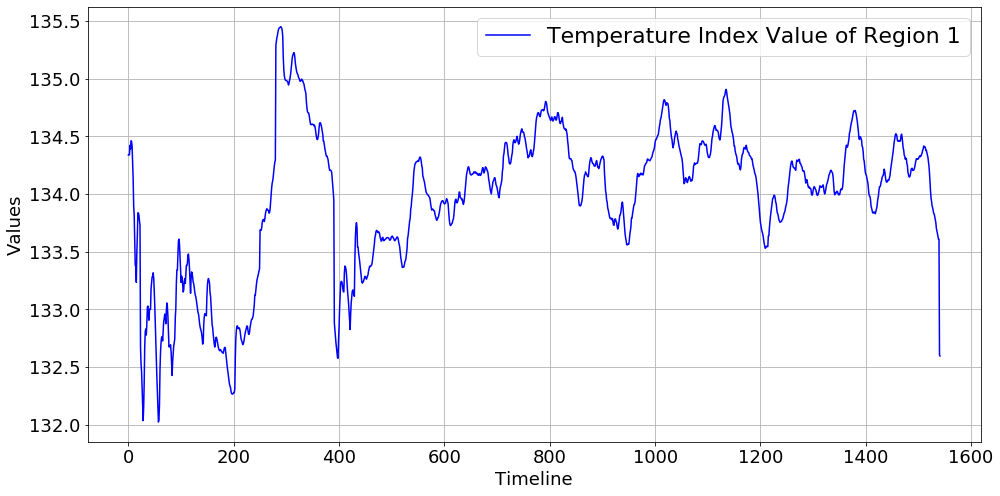

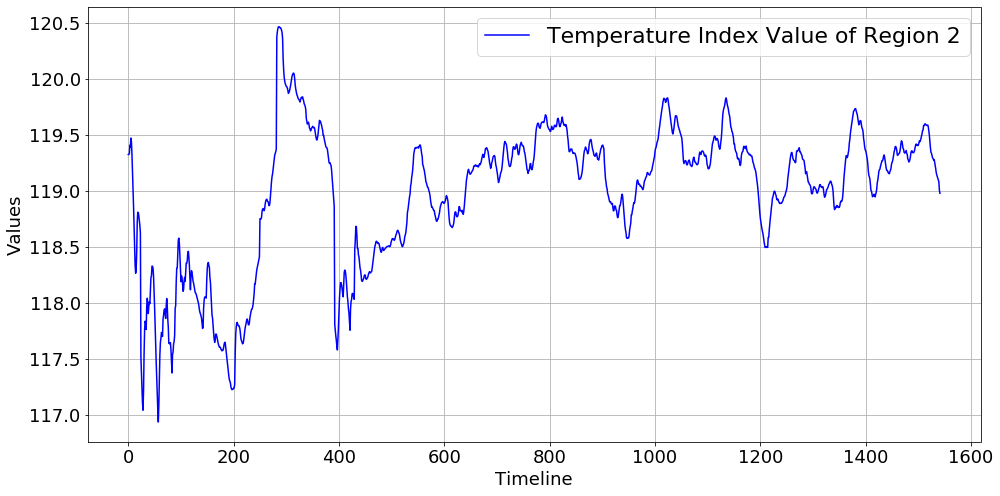

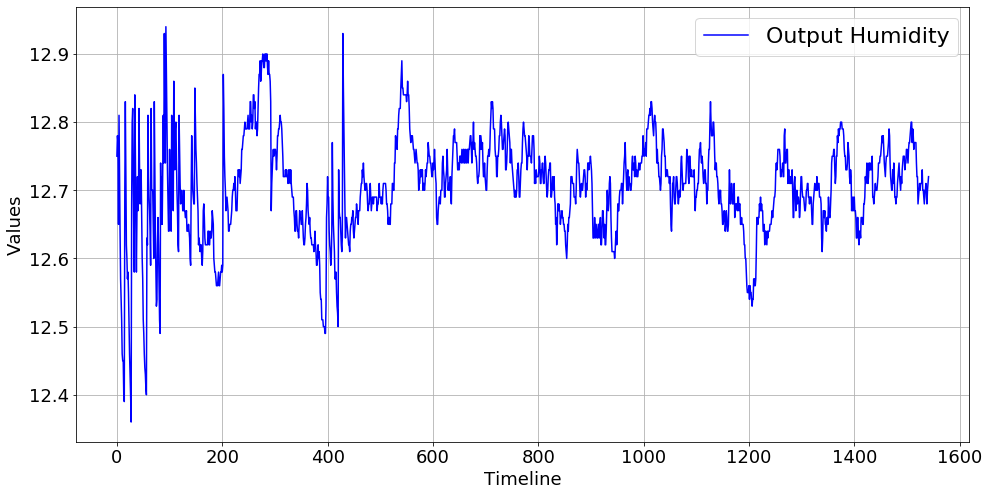

In [662]:
plt.figure(figsize = (16, 8))
plt.grid(True)
plt.plot(final_test_data['筒壁1区温度设定值'].values, 'b-')
plt.xlabel('Timeline', fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Values', fontsize=18)
plt.yticks(fontsize=18)
plt.legend(['Temperature Index Value of Region 1'],  loc='best', fontsize=22)
plt.show()

plt.figure(figsize = (16, 8))
plt.grid(True)
plt.plot(final_test_data['筒壁2区温度设定值'].values, 'b-')
plt.xlabel('Timeline', fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Values', fontsize=18)
plt.yticks(fontsize=18)
plt.legend(['Temperature Index Value of Region 2'],  loc='best', fontsize=22)
plt.show()

plt.figure(figsize = (16, 8))
plt.grid(True)
plt.plot(final_test_data['出口水分'].values, 'b-')
plt.xlabel('Timeline', fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Values', fontsize=18)
plt.yticks(fontsize=18)
plt.legend(['Outlet Humidity'],  loc='best', fontsize=22)
plt.show()

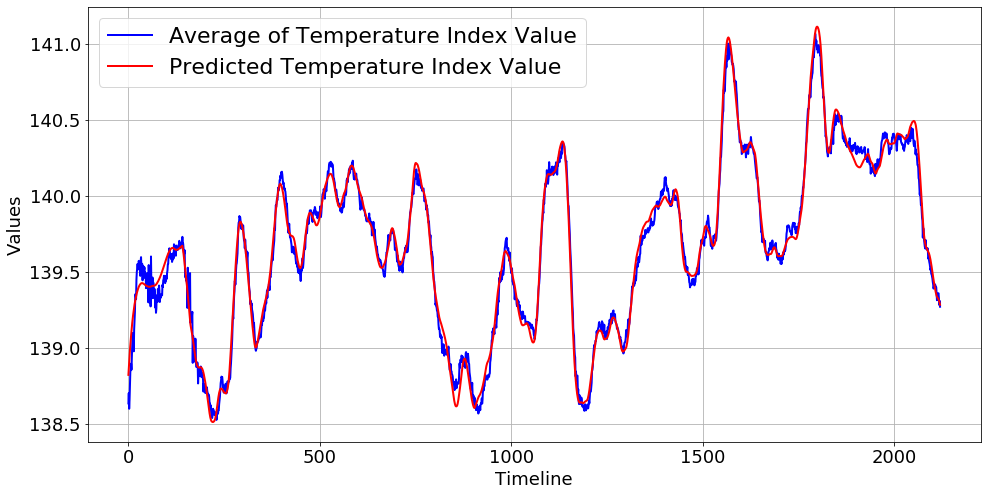

In [824]:
plot_result(pred[:, 0], final_X_label[:, 0])

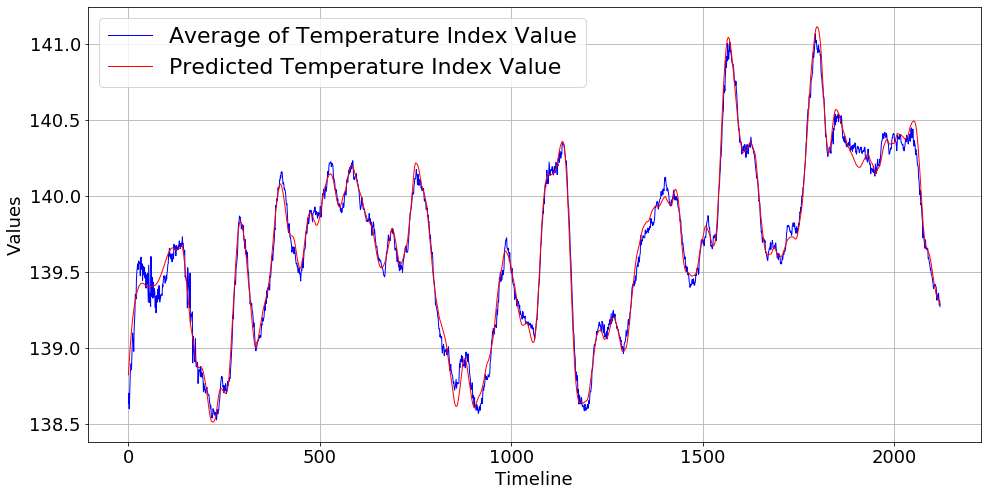

In [828]:
plot_result(pred[:, 0], final_X_label[:, 0])

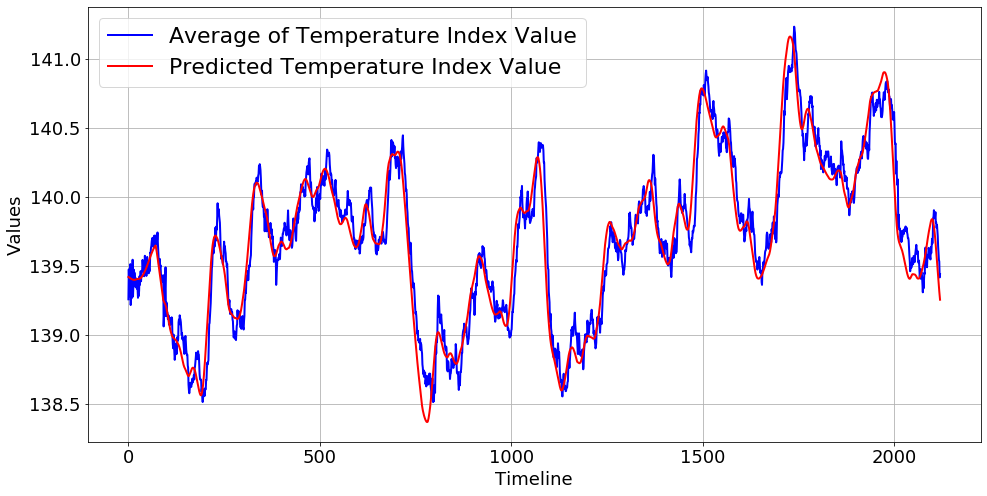

In [825]:
plot_result(pred[:, 1], final_X_label[:, 1])

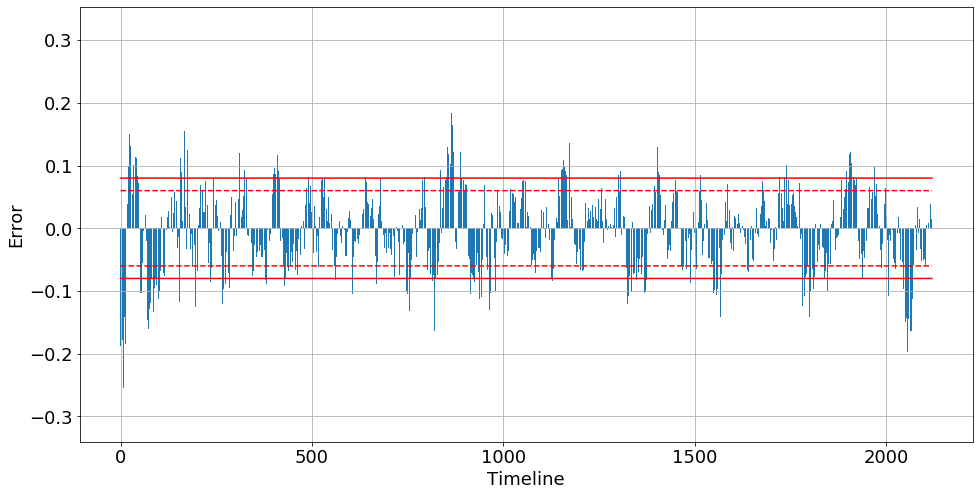

In [816]:
diff = pred[:, 0] - final_X_label[:, 0]

plt.figure(figsize = (16, 8))
plt.grid(True)
plt.bar(range(len(diff)), diff)
plt.plot(range(len(diff)), [0.08] * len(diff), 'r')
plt.plot(range(len(diff)), [-0.08] * len(diff), 'r')

plt.plot(range(len(diff)), [0.06] * len(diff), 'r--')
plt.plot(range(len(diff)), [-0.06] * len(diff), 'r--')
plt.xlabel('Timeline', fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Error', fontsize=18)
plt.yticks(fontsize=18)
plt.show()

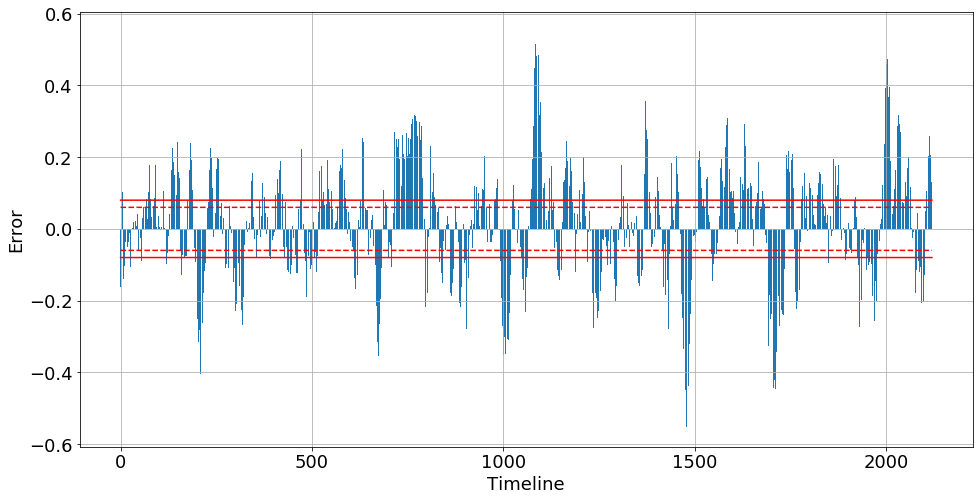

In [817]:
diff = pred[:, 1] - final_X_label[:, 1]

plt.figure(figsize = (16, 8))
plt.grid(True)
plt.bar(range(len(diff)), diff)

plt.plot(range(len(diff)), [0.08] * len(diff), 'r')
plt.plot(range(len(diff)), [-0.08] * len(diff), 'r')

plt.plot(range(len(diff)), [0.06] * len(diff), 'r--')
plt.plot(range(len(diff)), [-0.06] * len(diff), 'r--')

plt.xlabel('Timeline', fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Error', fontsize=18)
plt.yticks(fontsize=18)
plt.show()

## Grid Search

In [ ]:
result = []
for FEATURE_RANGE in [50, 60, 70, 80]:
    for LABEL_RANGE in [20, 25, 30, 35, 40]:
        train_dataset_list = []
        train_label_list = []

        for split_data_index, split_data in enumerate(split_data_per_number):
            start = datetime.now()

            sample_train_dataset, sample_train_label, _, _ = generate_data(split_data, split_data_index)

            train_dataset_list.append(sample_train_dataset)
            train_label_list.append(sample_train_label)

        sample_train_dataset = train_dataset_list[0]
        sample_train_label = train_label_list[0]

        for i in range(1, len(train_dataset_list)):
            sample_train_dataset = np.concatenate([sample_train_dataset, train_dataset_list[i]], axis=0)
            sample_train_label = np.concatenate([sample_train_label, train_label_list[i]], axis=0)

        X_train, X_test, y_train, y_test = train_test_split(sample_train_dataset, sample_train_label, test_size=0.1, random_state=6)
        scaler = StandardScaler()
        X_train_scaler = scaler.fit_transform(X_train)
        X_test_scaler = scaler.transform(X_test)

        clf = LinearRegression(normalize=True)
        clf.fit(X_train_scaler, y_train)

        pred = clf.predict(X_test_scaler)
        print('FEATURE_RANGE: {}, LABEL_RANGE: {}'.format(FEATURE_RANGE, LABEL_RANGE))
        print('mae: ', round(mean_absolute_error(y_test, pred), 3))
        print('---------')
        result.append(round(mean_absolute_error(y_test, pred), 3))

FEATURE_RANGE: 50, LABEL_RANGE: 20
mae:  0.086
---------
FEATURE_RANGE: 50, LABEL_RANGE: 25
mae:  0.094
---------
FEATURE_RANGE: 50, LABEL_RANGE: 30
mae:  0.1
---------
FEATURE_RANGE: 50, LABEL_RANGE: 35
mae:  0.105
---------
FEATURE_RANGE: 50, LABEL_RANGE: 40
mae:  0.11
---------
FEATURE_RANGE: 60, LABEL_RANGE: 20
mae:  0.073
---------
FEATURE_RANGE: 60, LABEL_RANGE: 25
mae:  0.082
---------
FEATURE_RANGE: 60, LABEL_RANGE: 30
mae:  0.089
---------
FEATURE_RANGE: 60, LABEL_RANGE: 35
mae:  0.095
---------
FEATURE_RANGE: 60, LABEL_RANGE: 40
mae:  0.1
---------
FEATURE_RANGE: 70, LABEL_RANGE: 20
mae:  0.065
---------
FEATURE_RANGE: 70, LABEL_RANGE: 25
mae:  0.074
---------
FEATURE_RANGE: 70, LABEL_RANGE: 30
mae:  0.08
---------


# 头料阶段

In [927]:
data = data[(data['设备状态'] == '启动') | (data['设备状态'] == '准备')]

In [866]:
adjust_one = {}
adjust_two = {}
init_one = {}
init_two = {}
input_humidity = {}

for number in data['牌号'].unique():
    sample_per_number = data[data['牌号'] == number]
    
    init_one_per_batch = []
    init_two_per_batch = []
    humidity_per_batch = []
    
    for batch in sample_per_number['批次'].unique():
        sample_per_batch = sample_per_number[sample_per_number['批次'] == batch]

        sample_per_batch['时间'] = sample_per_batch['时间'].map(lambda x: format_time(x))
        sample_per_batch = sample_per_batch.sort_values(by=['时间'], ascending=True)
        
        init_one_per_batch.append(sample_per_batch['筒壁1区温度设定值'].iloc[0])
        init_two_per_batch.append(sample_per_batch['筒壁2区温度设定值'].iloc[0])
        humidity_per_batch.append(sample_per_batch['入口水分'].iloc[5: 100].mean())
 
        for i in range(1, len(sample_per_batch) - 2):
            if sample_per_batch['筒壁1区温度设定值'].iloc[i + 2] - sample_per_batch['筒壁1区温度设定值'].iloc[i] > 0.8:
                if i < 70:
                    adjust_one[batch] = i
                    break
                
        for i in range(1, len(sample_per_batch) - 2):
            if sample_per_batch['筒壁2区温度设定值'].iloc[i + 2] - sample_per_batch['筒壁2区温度设定值'].iloc[i] > 0.8:
                if i < 140:
                    adjust_two[batch] = i        
                    break
    
    init_one[number] = init_one_per_batch
    init_two[number] = init_two_per_batch
    input_humidity[number] = humidity_per_batch
    
print('一区调整比例: {}, 调整时间: {}'.format(len(adjust_one)/ 618, 2 * round(np.mean(list(adjust_one.values())))))
print('二区调整比例: {}, 调整时间: {}'.format(len(adjust_two)/ 618, 2 * round(np.mean(list(adjust_two.values())))))

print('--------------------')
print('一区二区初始设定值: ')
for index, item in enumerate(init_one):
    print('{}: {}+-{}, \t {}+-{}'.format(item, np.round(np.mean(init_one[item]), 2), np.round(np.std(init_one[item]), 2), np.round(np.mean(init_two[item]), 2),np.round(np.std(init_two[item]), 2)))
11
print('--------------------')
print('入口水分: ')
for index, item in enumerate(init_one):
    print('{}: {}+-{}'.format(item, np.round(np.mean(input_humidity[item]), 2), np.round(np.std(input_humidity[item]), 2)))
    

一区调整比例: 0.9530744336569579, 调整时间: 32.0
二区调整比例: 0.959546925566343, 调整时间: 124.0
--------------------
一区二区初始设定值: 
Txy###: 132.92+-0.61, 	 117.92+-0.61
TG####A: 137.94+-0.72, 	 122.95+-0.74
TH####A: 133.06+-2.4, 	 119.11+-4.01
HSX###: 132.33+-1.06, 	 132.33+-1.06
DQMr##: 127.0+-0.0, 	 127.0+-0.0
HsxY##: 124.93+-0.58, 	 124.93+-0.58
ThQD##A: 138.0+-0.0, 	 123.0+-0.0
--------------------
入口水分: 
Txy###: 18.93+-0.15
TG####A: 19.07+-0.89
TH####A: 18.64+-0.33
HSX###: 21.34+-0.18
DQMr##: 20.87+-0.02
HsxY##: 19.7+-0.15
ThQD##A: 18.74+-0.04


In [932]:
MODEL_CRITERION_IN_START = 0.25 # 模型在头料阶段的标准，工艺标准为 0.5

stable_setting = {}

for number in data['牌号'].unique():
    sample_per_number = data[data['牌号'] == number]
    
    stable_per_batch = []
    
    for batch in sample_per_number['批次'].unique():
        sample_per_batch = sample_per_number[sample_per_number['批次'] == batch]
        sample_per_batch['时间'] = sample_per_batch['时间'].map(lambda x: format_time(x))
        sample_per_batch = sample_per_batch.sort_values(by=['时间'], ascending=True)
        
        humidity = sample_per_batch['出口水分']
        
        end = len(sample_per_batch) - 1
        start = len(sample_per_batch) - 1
        for i in range(len(sample_per_batch) - 1, 1, -1):
            if np.abs(humidity.iloc[i] - criterion[number]) <= MODEL_CRITERION_IN_START:
                start -= 1
            else: 
                break

        if start == end:
            continue
        
        stable_one = np.round(np.mean(sample_per_batch['筒壁1区温度设定值'].iloc[start - TOTAL_LAG: end - TOTAL_LAG]), 3)
        stable_two = np.round(np.mean(sample_per_batch['筒壁2区温度设定值'].iloc[start - TOTAL_LAG: end - TOTAL_LAG]), 3)
        stable_per_batch.append([stable_one, stable_two])

    stable_setting[number] = stable_per_batch
    
for number in stable_setting:
    setting = np.array(stable_setting[number])
    print(number, np.round(np.mean(setting, axis=0), 2), np.round(np.std(setting, axis=0), 2))

Txy### [134.72 119.53] [0.67 0.74]
TG####A [139.74 124.56] [0.7  0.74]
TH####A [134.79 120.46] [2.37 3.57]
HSX### [134.21 133.94] [1.71 1.74]
DQMr## [129.65 129.43] [0. 0.]
HsxY## [126.5  126.27] [0.83 0.83]
ThQD##A [138.14 123.07] [1.12 1.04]


In [892]:
print(data['牌号'].unique())

sample_per_number = data[data['牌号'] == 'HsxY##']
sample_per_number['批次'].unique()

array(['Txy###', 'TG####A', 'HSX###', 'TH####A', 'DQMr##', 'ThQD##A',
       'HsxY##'], dtype=object)

In [924]:
draw_split_data(sample_per_number[sample_per_number['批次'] == '1909HsxY##046_03'], 'all-HsxY##-1909HsxY##046_03')

# 尾料阶段

In [897]:
data = data[(data['设备状态'] == '收尾')]

In [901]:
size = []
for number in data['牌号'].unique():
    sample_per_number = data[data['牌号'] == number]
    
    for batch in sample_per_number['批次'].unique():
        sample_per_batch = sample_per_number[sample_per_number['批次'] == batch]
        
        size.append(sample_per_batch.shape[0])


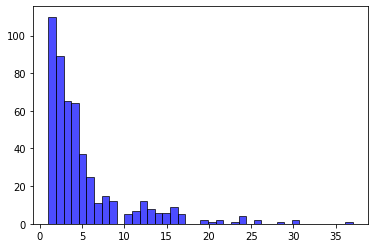

In [911]:
import matplotlib.pyplot as plt
import matplotlib
plt.hist(size, bins=40, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.show()